## 1. Setup

Install required text processing libraries for the example

In [37]:
# !pip install nltk
# import nltk

In [38]:
# nltk.download('stopwords')

In [39]:
# nltk.download('punkt')

## 2. Creating Text Representations

Text data needs to be converted to numeric representations before they can be used to train deep learning models. The Spam classification feature data is converted to TF-IDF vectors and the target variable is converted to one-hot encoding.

In [40]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import pickle

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2


#Load chat Data and review content
chat_data = pd.read_csv("chats.csv")

print("\nLoaded Data :\n------------------------------------")
print(chat_data.head())

#Separate feature and target data
chat_classes_raw = chat_data["CLASS"]
chat_messages = chat_data["MESSAGE"]
num_classes = chat_classes_raw.unique().shape[0]


Loaded Data :
------------------------------------
          CLASS                               MESSAGE
0  company_info         What is Handyman Prosthetics?
1  company_info                     What is Handyman?
2  company_info                Tell me about Handyman
3  company_info    Tell me about handyman prosthetics
4  company_info  Hi Handy. Tell me about your company


In [41]:

import nltk
import tensorflow as tf
from nltk.corpus import stopwords

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#Custom tokenizer to remove stopwords and use lemmatization
def customtokenize(str):
    #Split string as tokens
    tokens=nltk.word_tokenize(str)
    #Filter for stopwords
    nostop = list(filter(lambda token: token not in stopwords.words('english'), tokens))
    #Perform lemmatization
    lemmatized=[lemmatizer.lemmatize(word) for word in nostop ]
    return lemmatized

from sklearn.feature_extraction.text import TfidfVectorizer

#Build a TF-IDF Vectorizer model
vectorizer = TfidfVectorizer(tokenizer=customtokenize)

#Transform feature input to TF-IDF
tfidf=vectorizer.fit_transform(chat_messages)
pickle.dump( vectorizer, open( "bot_vectorizer.p", "wb" ) )

#Convert TF-IDF to numpy array
tfidf_array = tfidf.toarray()

#Build a label encoder for target variable to convert strings to numeric values.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()


chat_classes = label_encoder.fit_transform(
                                chat_classes_raw)

np.save('bot_label_encoder.npy', label_encoder.classes_)
#Convert target to one-hot encoding vector
chat_classes = tf.keras.utils.to_categorical(chat_classes,num_classes)

print("TF-IDF Matrix Shape : ", tfidf.shape)
print("One-hot Encoding Shape : ", chat_classes.shape)

X_train,X_test,Y_train,Y_test = train_test_split( tfidf_array, chat_classes, test_size=0.10)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vssashar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


TF-IDF Matrix Shape :  (451, 73)
One-hot Encoding Shape :  (451, 7)


## 3. Building and Evaluating the Model

In [42]:

#Setup Hyper Parameters for building the model
NB_CLASSES=num_classes
N_HIDDEN=32
model = tf.keras.models.Sequential()

model.add(keras.layers.Dense(N_HIDDEN,
                             input_shape=(X_train.shape[1],),
                              name='Hidden-Layer-1',
                              activation='relu'))

model.add(keras.layers.Dense(N_HIDDEN,
                              name='Hidden-Layer-2',
                              activation='relu'))
model.add(keras.layers.Dense(N_HIDDEN,
                              name='Hidden-Layer-3',
                              activation='relu'))

model.add(keras.layers.Dense(NB_CLASSES,
                             name='Output-Layer',
                             activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 32)                2368      
                                                                 
 Hidden-Layer-2 (Dense)      (None, 32)                1056      
                                                                 
 Hidden-Layer-3 (Dense)      (None, 32)                1056      
                                                                 
 Output-Layer (Dense)        (None, 7)                 231       
                                                                 
Total params: 4,711
Trainable params: 4,711
Non-trainable params: 0
_________________________________________________________________



Training Progress:
------------------------------------
Epoch 1/30
41/41 [==============================] - 1s 5ms/step - loss: 1.7854 - accuracy: 0.3981 - val_loss: 1.5891 - val_accuracy: 0.5432
Epoch 2/30
41/41 [==============================] - 0s 2ms/step - loss: 1.5077 - accuracy: 0.4259 - val_loss: 1.3269 - val_accuracy: 0.5062
Epoch 3/30
41/41 [==============================] - 0s 2ms/step - loss: 1.3312 - accuracy: 0.4722 - val_loss: 1.1819 - val_accuracy: 0.6790
Epoch 4/30
41/41 [==============================] - 0s 2ms/step - loss: 1.1470 - accuracy: 0.6605 - val_loss: 1.0085 - val_accuracy: 0.7654
Epoch 5/30
41/41 [==============================] - 0s 3ms/step - loss: 0.9305 - accuracy: 0.7315 - val_loss: 0.8045 - val_accuracy: 0.7778
Epoch 6/30
41/41 [==============================] - 0s 2ms/step - loss: 0.7461 - accuracy: 0.7346 - val_loss: 0.7049 - val_accuracy: 0.7901
Epoch 7/30
41/41 [==============================] - 0s 3ms/step - loss: 0.6023 - accuracy: 0.7531 - val

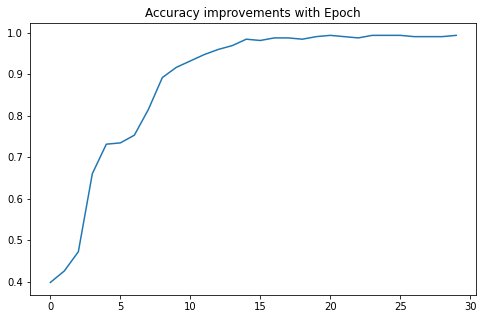


Evaluation against Test Dataset :
------------------------------------
2/2 [==============================] - 0s 3ms/step - loss: 0.0172 - accuracy: 1.0000


[0.01716342382133007, 1.0]

In [43]:
#Make it verbose so we can see the progress
VERBOSE=1

#Setup Hyper Parameters for training
BATCH_SIZE=8
EPOCHS=30
VALIDATION_SPLIT=0.2

print("\nTraining Progress:\n------------------------------------")

history=model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT)

print("\nAccuracy during Training :\n------------------------------------")
import matplotlib.pyplot as plt

pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(X_test,Y_test)

## 4. Saving and Loading Models

The training and inference environments are usually separate. Models need to be saved after they are validated. They are then loaded into the inference environments for actual prediction

In [44]:
#Saving a model
    
model.save("chatbot_model")
    

INFO:tensorflow:Assets written to: chatbot_model\assets


INFO:tensorflow:Assets written to: chatbot_model\assets


In [45]:
#Loading a Model 
loaded_model = keras.models.load_model("chatbot_model")

#Print Model Summary
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-Layer-1 (Dense)      (None, 32)                2368      
                                                                 
 Hidden-Layer-2 (Dense)      (None, 32)                1056      
                                                                 
 Hidden-Layer-3 (Dense)      (None, 32)                1056      
                                                                 
 Output-Layer (Dense)        (None, 7)                 231       
                                                                 
Total params: 4,711
Trainable params: 4,711
Non-trainable params: 0
_________________________________________________________________


In [46]:
label_encoder.classes_

array(['all_products', 'buy_request', 'company_info', 'demo_request',
       'end_convo', 'exoskeleton_product', 'prosthesis_products'],
      dtype=object)

## 5. Predicting for Text

In [47]:
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn import preprocessing

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vssashar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [48]:
#Predict for multiple samples using batch processing
#Custom tokenizer to remove stopwords and use lemmatization
def customtokenize(str):
    #Split string as tokens
    tokens=nltk.word_tokenize(str)
    #Filter for stopwords
    nostop = list(filter(lambda token: token not in stopwords.words('english'), tokens))
    #Perform lemmatization
    lemmatized=[lemmatizer.lemmatize(word) for word in nostop ]
    return lemmatized

#Convert input into IF-IDF vector using the same vectorizer model
vectorizer = pickle.load( open( "bot_vectorizer.p", "rb" ) );
predict_tfidf=vectorizer.transform(["tell me about hand prosthetics",
                                    "how does your product work","Not needed","Thank you"]).toarray();

# print(predict_tfidf.shape)

encoder = preprocessing.LabelEncoder();
encoder.classes_ = np.load('bot_label_encoder.npy',allow_pickle=True);
# print(encoder.classes_)
#Predict using model
prediction=np.argmax( loaded_model.predict(predict_tfidf), axis=1 );

# print('Prediction metrics: ',loaded_model.predict(predict_tfidf))
print("Prediction Output:" , prediction);

#Print prediction classes
print("Prediction Classes are ", encoder.inverse_transform(prediction));

1/1 [==============================] - 0s 44ms/step
Prediction Output: [6 3 4 4]
Prediction Classes are  ['prosthesis_products' 'demo_request' 'end_convo' 'end_convo']


## 6. Loading replies
Replies need to be saved into "bot_replies" folder with names as <bot_message_class>.txt

In [61]:
bot_reply_classes = ['start_convo']+list(encoder.classes_) 
bot_replies = {}
for reply_class in bot_reply_classes:
    with open('bot_replies/'+reply_class+'.txt') as f:
        bot_replies[reply_class] = f.readlines()

In [62]:
for reply_class in bot_reply_classes:

    print(reply_class+':')
    for line in bot_replies[reply_class]:
        print(line.strip())
    print("_____________")    

start_convo:
Hi! I am Handy, AI chatbot of Handyman Prosthetics. How may I help you?
_____________
all_products:
Here's our complete catalogue:
MARK I: For arm amputees. Our simple and light weight model of arm prosthesis. Suitable for simple tasks.
MARK II: For arm amputees. An advanced and dextrous arm. Involves softroboric for best grip and individual finger control.
EXO 0: For hand injury rehabilitation and hand paralysis. Comfortable, light-weight and simple.
EXO I: For hand injury rehabilitation and hand paralysis. Dextrous movements and powerful gripping action.
_____________
buy_request:
Prosthesis is a very personalized solution, differening from user to user.
Kindly provide your details here and we will contact you:
https://forms.gle/C6Em8mSkH5zgbS576
_____________
company_info:
Handyman Prosthetics create hand prosthesis and exoskeleton support for people who lost their arms or the ability to control it.
Our perosonalized solutions enable them to carry out simple day to day 

## 7. Chatbot in action

In [64]:
start_state = 'start_convo'
end_state = 'end_convo'

state = start_state
while state!=end_state:
    for line in bot_replies[state]:
        print('Handy: '+line.strip())
        
    user_reply = input('user: ')
    
    predict_tfidf=vectorizer.transform([user_reply]).toarray();
    prediction=np.argmax( loaded_model.predict(predict_tfidf), axis=1 );
    
    state = encoder.inverse_transform(prediction)[0]
#     print(state)
for line in bot_replies[state]:
    print('Handy: '+line.strip())

Handy: Hi! I am Handy, AI chatbot of Handyman Prosthetics. How may I help you?
user: Hi Handy. Tell me about your company
1/1 [==============================] - 0s 19ms/step
Handy: Handyman Prosthetics create hand prosthesis and exoskeleton support for people who lost their arms or the ability to control it.
Handy: Our perosonalized solutions enable them to carry out simple day to day tasks without having to rely on others.
user: Nice. Tell me about all your products
1/1 [==============================] - 0s 15ms/step
Handy: Here's our complete catalogue:
Handy: MARK I: For arm amputees. Our simple and light weight model of arm prosthesis. Suitable for simple tasks.
Handy: MARK II: For arm amputees. An advanced and dextrous arm. Involves softroboric for best grip and individual finger control.
Handy: EXO 0: For hand injury rehabilitation and hand paralysis. Comfortable, light-weight and simple.
Handy: EXO I: For hand injury rehabilitation and hand paralysis. Dextrous movements and powe